# Extract and save LFM observations from National Fuel Moisture Database
Last updated: Kevin Varga, 05/20/2024

**Inputs:**
* NFMD LFM text files
* SBC Fire LFM observations csv
* Spatial domain (WRF) <br>

**Outputs:**
* lfm_crop.csv - spatiotemporal cropped LFM dataframe <br>
* lfm_crop_site_loc.csv - site name, lat/lon, elevation of cropped LFM obs <br>

**Plots:**
* LFM time series at each LFM crop sample location
* Distribution comparison plot of chamise, chamise_new_growth, and chamise_old_growth values

In [3]:
import pandas as pd
import numpy as np
import xarray as xr

In [4]:
# Function to detect if LFM values at individual sample locations overlap
def get_overlap(r1,r2):
    """Determines if two date ranges have overlap
    
    Args:
        r1: date range 1
        r2: date range 2
        
    Returns:
        Date range between overlap
    """
    
    latest_start=max(r1[0],r2[0])
    earliest_end=min(r1[-1],r2[-1])
    delta=pd.date_range(start=latest_start, end=earliest_end)

    return delta

In [20]:
obs_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/'
# Path for raw wrf outputs
wrf_path = '/home/perseverance-clivac/wrf_sbarbara/wrfout/2018/'

In [12]:
# Read in the three national fuel moisture database (NFMD) data tables
# Data tables available for download at https://github.com/wmjolly/pyNFMD
df_dat = pd.read_csv(obs_path + 'nfmd/Tbldata.txt', low_memory=False)
df_site = pd.read_csv(obs_path + 'nfmd/Tblsites.txt')
df_fuel = pd.read_csv(obs_path + 'nfmd/Tblfuels.txt')

In [13]:
# Make the date readable by python
df_dat['DateTime']=pd.to_datetime(df_dat['date'].astype(str) + " 13", format='%Y-%m-%d %H')
df_merge1 = df_dat.merge(df_fuel,on='fuel')
df_merge2 = df_merge1.merge(df_site, on =['gacc','site'])
df_merge2.rename(columns=lambda x: x.strip(), inplace=True)
# Fix the coordinates
latsplit = df_merge2['lat'].str.split(pat = '-', expand = True).astype(float)
lonsplit = df_merge2['lng'].str.split(pat = '-', expand = True).astype(float)
df_merge2['Latitude'] = latsplit[0] + ((latsplit[1]+(latsplit[2]/60))/60)
df_merge2['Longitude'] = (lonsplit[0] + ((lonsplit[1]+(lonsplit[2]/60))/60)) * -1
df_merge2.drop(['ID_x','grup_x','state_x','old_fuel','ID_y','states'],axis=1,inplace=True)
df_lfm = df_merge2

# Rrop unneeded columns
df_lfm_nfmd = df_lfm.drop(columns=['grup_y','date','scientific_name','ID','date_created','fuel_model','fuel_loading',
                  'default_end_month','default_beg_month', 'remarks', 'raws_id','state_y', 'active', 'jurisdiction', 'raws','lng', 'lat'])

In [18]:
# Read in lfm dataframe from santa barbara county fire, which is not included in the nfmd database
# Available through sbc fire, https://sbcfire.com/wildfire-predictive-services/
df_lfm_sbcfire = pd.read_csv(obs_path + 'sbc_fire_lfm.csv')

# Concatenate the two dataframes together
df_lfm = pd.concat([df_lfm_nfmd, df_lfm_sbcfire])

# Rename columns
df_lfm.rename(columns = {'DateTime':'date', 'Latitude':'latitude', 'Longitude':'longitude'}, inplace = True)

# Convert dates to datetime format
df_lfm['date'] = pd.to_datetime(df_lfm['date'])

In [21]:
# Subset LFM observations to time/date and lat/lon of Santa Barbara County CLIVAC WRF climatology
# Request SBC WRF data here, https://clivac.eri.ucsb.edu/clivac/SBCWRFD/index.html

# Read in raw wrf output for spatial domain
wrf_ds = xr.open_dataset(wrf_path + 'wrfout_d04_2017-12-04_00:00:00')

# Files are separate, necesitating hard coding for first and last date
start_datetime = pd.to_datetime('1987-07-01 00:00:00')
end_datetime = pd.to_datetime('2019-06-30 00:00:00')

# Outer WRF border is left off due to poor quality of data
south_lat = wrf_ds['XLAT_V'][0,1,0].to_numpy()
north_lat = wrf_ds['XLAT_V'][0,-2,0].to_numpy()
west_lon = wrf_ds['XLONG_U'][0,0,1].to_numpy()
east_lon = wrf_ds['XLONG_U'][0,0,-2].to_numpy()

wrf_ds.close()

In [22]:
print(south_lat, north_lat, west_lon, east_lon)

33.512978 35.498436 -121.24859 -118.589745


In [23]:
# Mask data with beginning and end date
mask = (df_lfm['date'] >= start_datetime) & (df_lfm['date'] <= end_datetime)
df_lfm = df_lfm.loc[mask]

# Mask data with lat and lon
mask = (df_lfm['latitude'] >= south_lat) & (df_lfm['latitude'] <= north_lat) & \
       (df_lfm['longitude'] >= west_lon) & (df_lfm['longitude'] <= east_lon)
lfm_crop = df_lfm.loc[mask]
lfm_crop.reset_index(drop=True, inplace = True)

In [26]:
# Create a copy of the DataFrame first to ensure we're working with a new object
lfm_clean = lfm_crop.copy()

# Clean up fuel column
lfm_clean['fuel'] = (lfm_clean['fuel']
    .astype('string')
    .str.lower()
    .str.replace(", ", "_")
    .str.replace(" ", "_")
    .str.replace("sagebrush", "sage")
)

# Clean up category column
lfm_clean['category'] = (lfm_clean['category']
    .astype('string')
    .str.lower()
)

# Clean up site column
lfm_clean['site'] = (lfm_clean['site']
    .astype('string')
    .str.lower()
    .str.replace(', ', '_')
    .str.replace(' ', '_')
)

# Set index for the site-specific modifications
lfm_clean.set_index('site', inplace=True)

# Update Frazier Park new growth entries
new_growth_replacements = {
    'manzanita_greenleaf': 'manzanita_greenleaf_new',
    'ceanothus_buckbrush': 'ceanothus_buckbrush_new',
    'mahogany_birchleaf_mountain': 'mahogany_birchleaf_mountain_new'
}

for old, new in new_growth_replacements.items():
    lfm_clean.loc['frazier_park_new_growth', 'fuel'] = (
        lfm_clean.loc['frazier_park_new_growth', 'fuel']
        .str.replace(old, new)
    )

# Update Frazier Park old growth entries
old_growth_replacements = {
    'manzanita_greenleaf': 'manzanita_greenleaf_old',
    'ceanothus_buckbrush': 'ceanothus_buckbrush_old',
    'sage_black': 'sage_black_old',
    'mahogany_birchleaf_mountain': 'mahogany_birchleaf_mountain_old'
}

for old, new in old_growth_replacements.items():
    lfm_clean.loc['frazier_park_old_growth', 'fuel'] = (
        lfm_clean.loc['frazier_park_old_growth', 'fuel']
        .str.replace(old, new)
    )

# Reset index and get unique values
lfm_clean.reset_index(inplace=True)
all_sites = pd.unique(lfm_clean['site'])
all_fuels = pd.unique(lfm_clean['fuel'])

In [32]:
#make multiindex with site and date, then sort by site then date
lfm_clean = lfm_clean.set_index(['site', 'date'])
lfm_clean = lfm_clean.sort_index(level=[0,1])

#identify fuel types that the below code will search for sites where all match
matches = ['chamise','chamise_new_growth']
matches_l = []

#identify sites that include both fuel types in matches variable
for i, site_name in enumerate(all_sites):
    # subset each observation site's fuel types
    tmp = lfm_crop.loc[site_name, 'fuel'].values
    # identify which sites have observations for both chamise and chamise_new_growth
    if all([x in tmp for x in matches]):
        matches_l.append(site_name)

In [33]:
# loop through sites where matches exist
for i, site_name in enumerate(matches_l):
    # subset the fuels column at each site
    site_df = lfm_clean.loc[site_name, 'fuel']
    # find the date range of designated fuel types
    cham_range = site_df.loc[site_df == 'chamise'].index
    new_cham_range = site_df.loc[site_df == 'chamise_new_growth'].index
    # find the overlapping date range
    output = get_overlap(cham_range, new_cham_range)
    
    if len(output) > 0:
        print(site_name + ' DOES HAVE OVERLAP!')
        # reindex to integers instead of dates
        site_df = site_df.to_frame()
        site_df.reset_index(inplace=True, drop=False)
        site_df['date'] = pd.to_datetime(site_df['date'])
        # find the index values of the beginning/end of overlap period
        idx_start = site_df.loc[site_df['date'] == output[0]].index
        idx_end = site_df.loc[site_df['date'] == output[-1]].index
        
        # loop through overlap period and nan designated fuel type
        for i in range(idx_start[0], idx_end[-1]):
            if site_df.loc[i, 'fuel'] == 'chamise': site_df.loc[i, 'fuel'] = np.nan
        
        # replace the nan filled fuel types into the larger dataframe
        lfm_clean.loc[site_name, 'fuel'] = site_df['fuel'].values

    else:
        print(site_name + ' does not have overlap')

san_marcos DOES HAVE OVERLAP!
gifford DOES HAVE OVERLAP!
reyes_creek DOES HAVE OVERLAP!
los_alamos DOES HAVE OVERLAP!
upper_oso DOES HAVE OVERLAP!
rose_valley DOES HAVE OVERLAP!
oak_flat DOES HAVE OVERLAP!
tepusquet does not have overlap
refugio does not have overlap
harris_grade does not have overlap
cachuma does not have overlap
west_gaviota does not have overlap


In [36]:
# Remove nan rows, showing how many overlapping observations
print(len(lfm_clean))
lfm_clean = lfm_clean.loc[lfm_clean['fuel'].notna()]
print(len(lfm_clean))

11506
10748


In [37]:
# Change chamise new growth label to chamise
# Example plot below to show that chamise label aligns with new growth, not old growth
lfm_clean.loc[:, 'fuel'] = lfm_clean.loc[:, 'fuel'].str.replace('chamise_new_growth', 'chamise')
all_fuels = pd.unique(lfm_clean.loc[:, 'fuel'])

In [38]:
# Remove lfm observations above 500% and below 30%
print(len(lfm_clean))
lfm_clean.where(lfm_clean['percent'] < 500, np.nan, inplace = True)
print(len(lfm_clean))
lfm_clean.where(lfm_clean['percent'] > 30, np.nan, inplace = True)
print(len(lfm_clean))

# Remove nan values
lfm_clean = lfm_clean.loc[lfm_clean['percent'].notna()]

10748
10748
10748


In [39]:
# Remove sites with less than 25 lfm observations due to computational demand
remove = [all_sites[i] for i in range(len(all_sites)) if len(lfm_clean.loc[all_sites[i]]) < 25]
lfm_clean = lfm_clean.drop(index=remove, level=0)

# Remove frazier_park_new_growth and frazier_park_old_growth sites, which show poor data quality
lfm_clean = lfm_clean.drop(index=(['frazier_park_new_growth', 'frazier_park_old_growth']), level=0)

lfm_clean = lfm_clean.reset_index()
all_sites = pd.unique(lfm_clean['site'])

In [40]:
# Subset only observation sites and dates
lfm_clean_time_loc = lfm_clean.drop(columns=['fuel','percent', 'category', 'slope', 'aspect'])
lfm_clean_time_loc = lfm_clean_time_loc.reset_index(drop=True)

# Find number of observations at each site
tmp = [len(lfm_clean[lfm_clean['site'] == all_sites[i]]) for i in range(len(all_sites))]

# Subset only observation site locations and number of observations at each site
lfm_clean_loc = lfm_clean_time_loc.drop_duplicates(subset='site')
lfm_clean_loc = lfm_clean_loc.reset_index(drop=True)
lfm_clean_loc = lfm_clean_loc.drop(columns=['date'])
lfm_clean_loc.insert(5, 'n_obs', tmp)

In [39]:
# Save dataframe of cropped lfm observations
lfm_clean.to_csv('/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/lfm_crop.csv', index=False)

# Save dataframe of lfm sample site locations
lfm_clean_loc.to_csv('/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/lfm_crop_site_loc.csv', index=False)

### Plot LFM location time series

In [21]:
import matplotlib.pyplot as plt

/home/sbarc/students/varga/miniconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/home/sbarc/students/varga/miniconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/home/sbarc/students/varga/miniconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are re

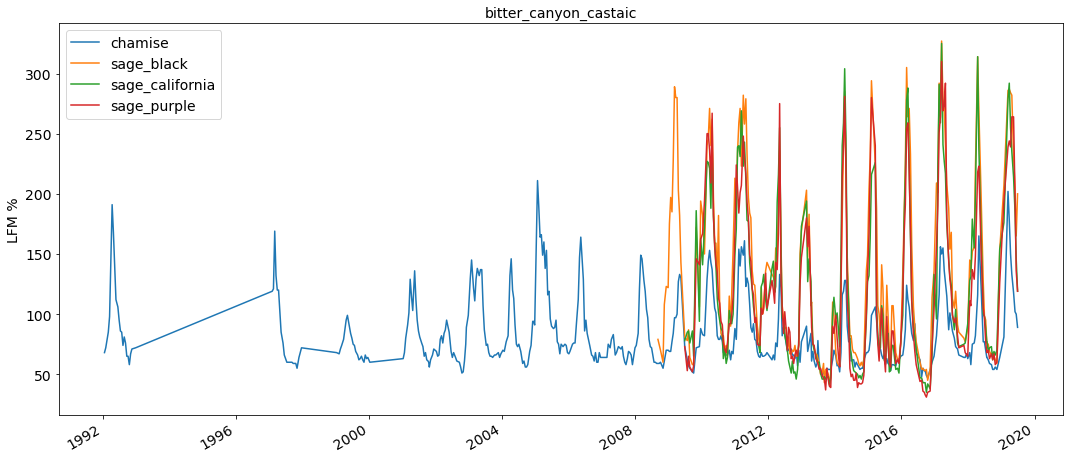

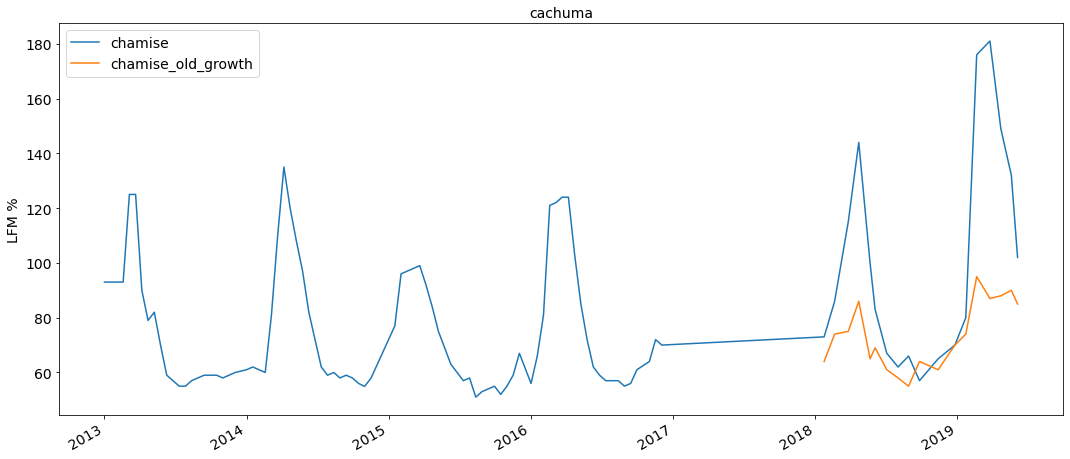

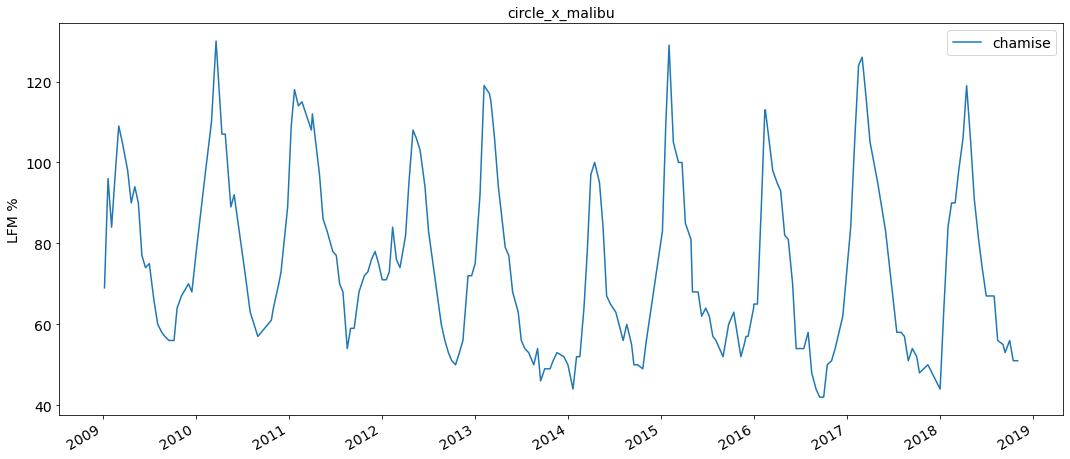

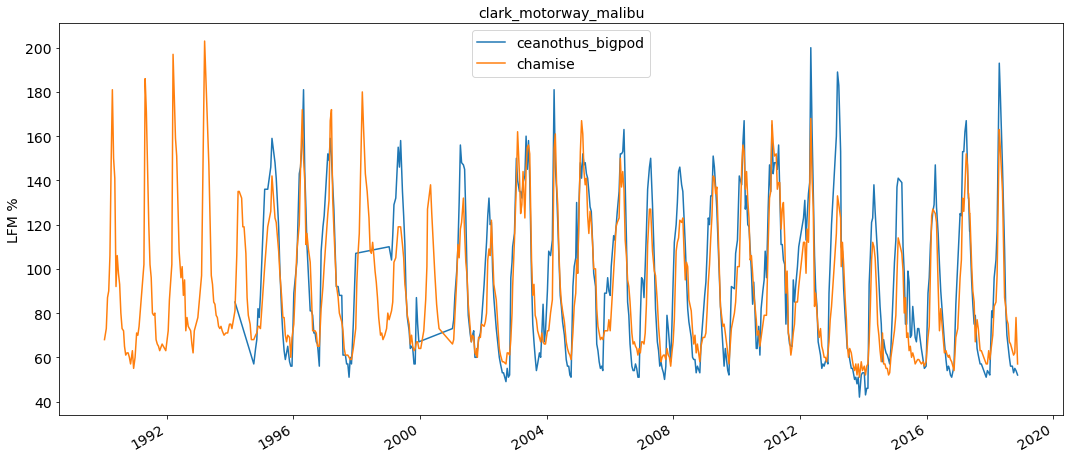

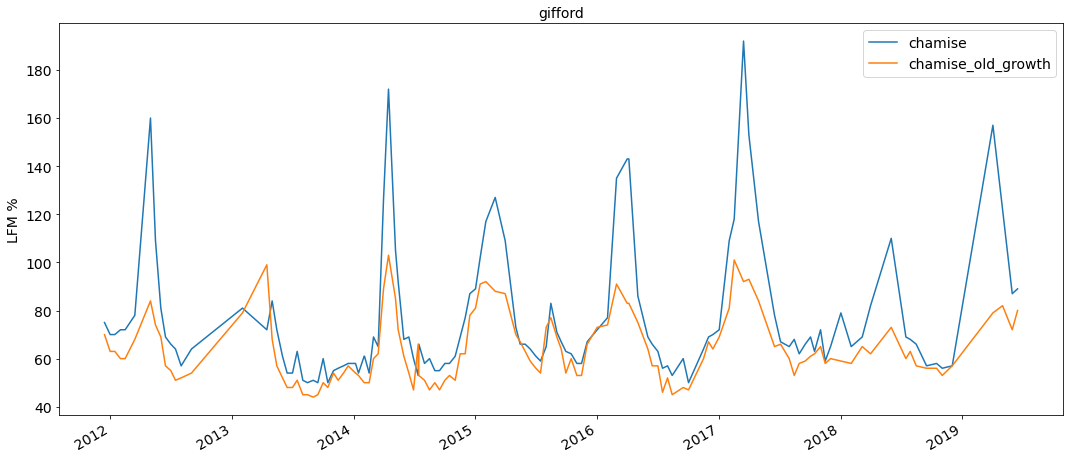

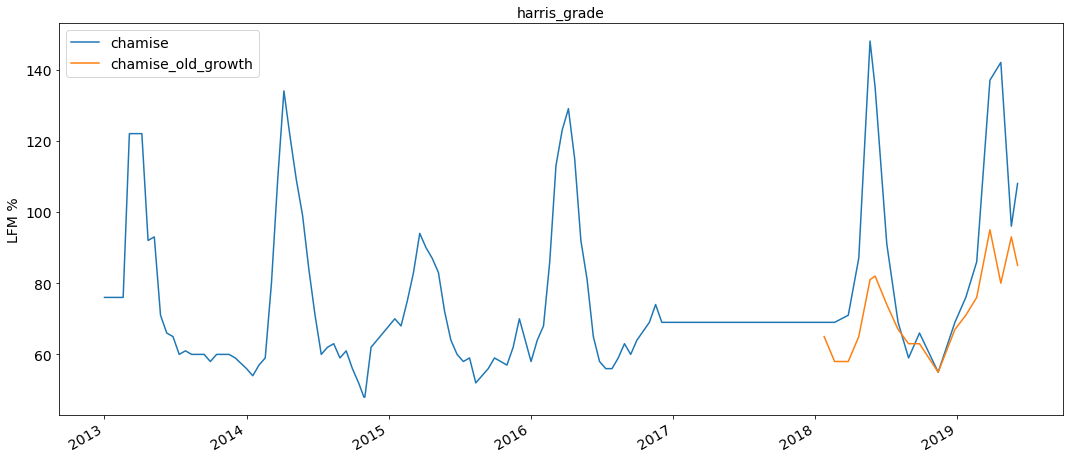

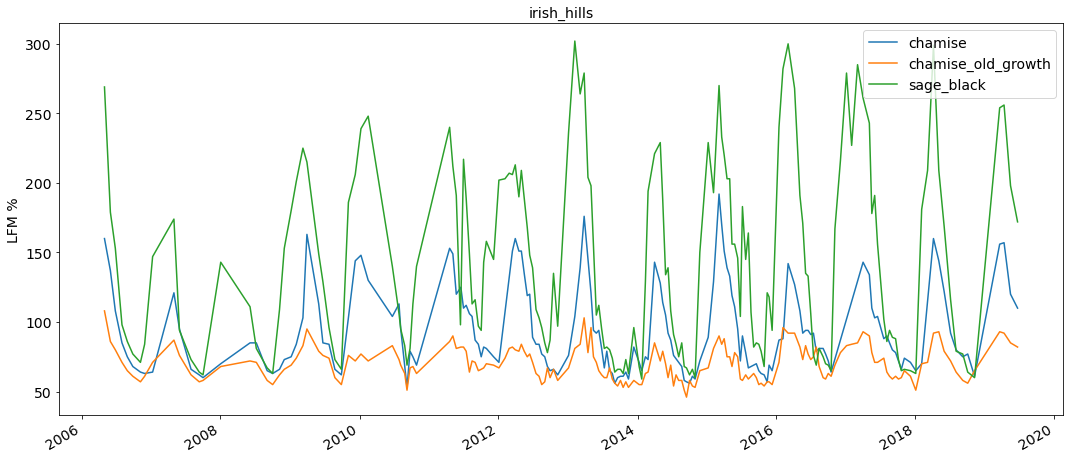

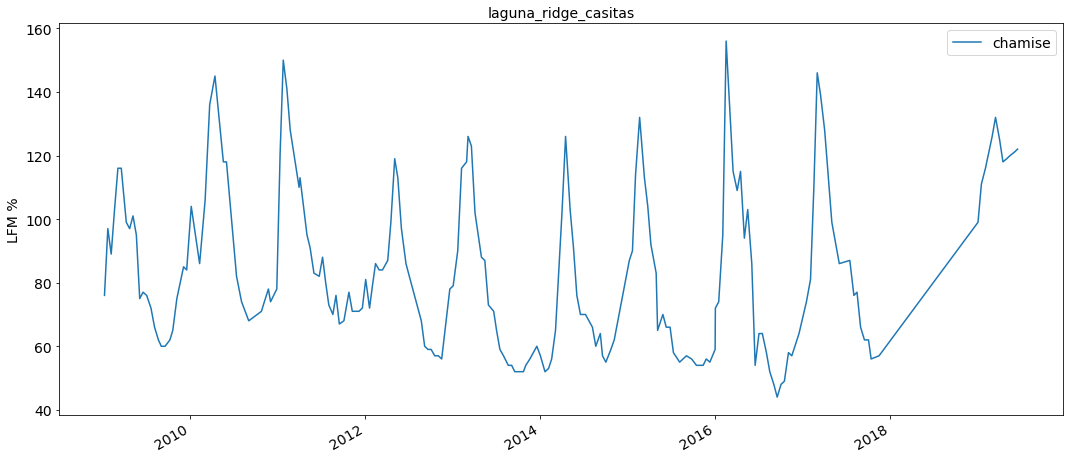

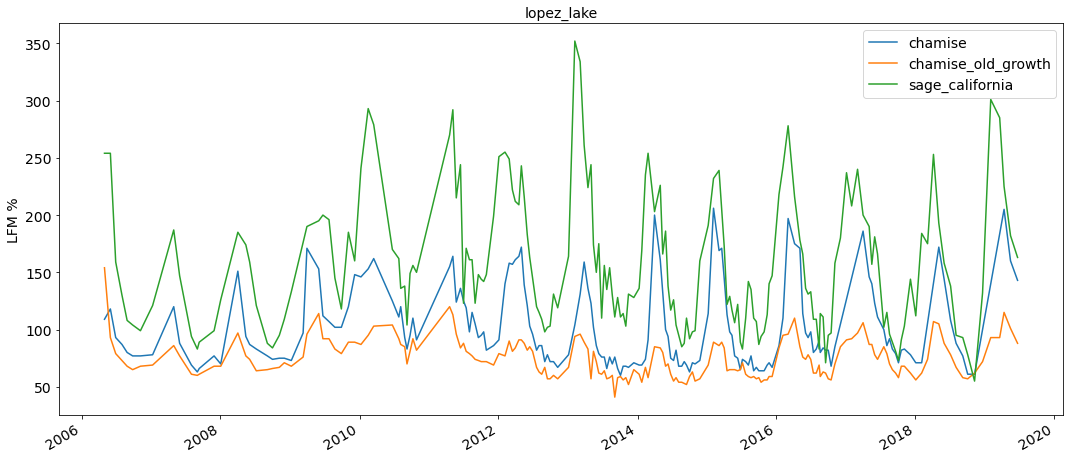

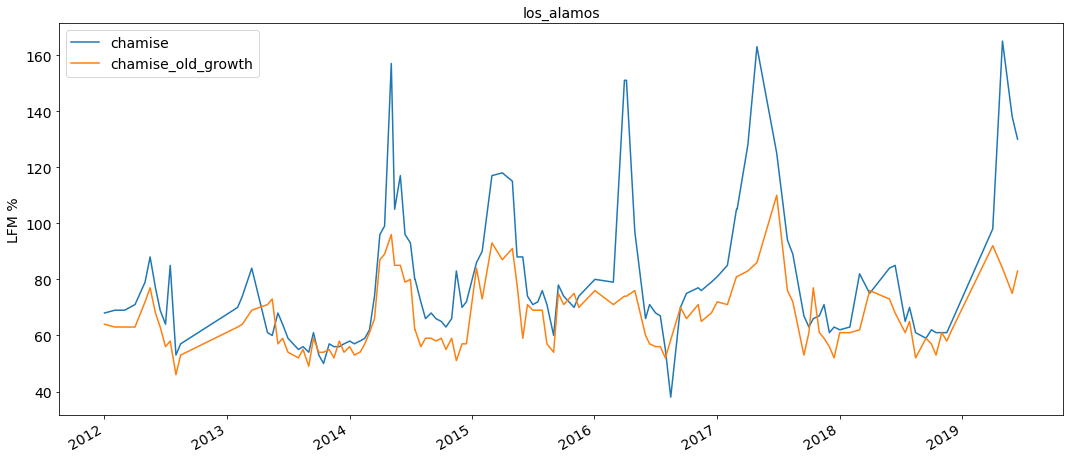

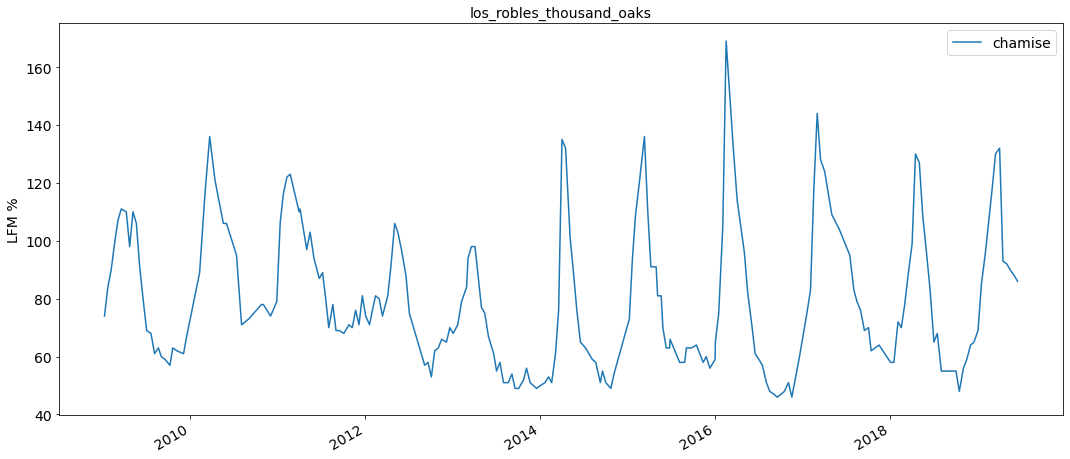

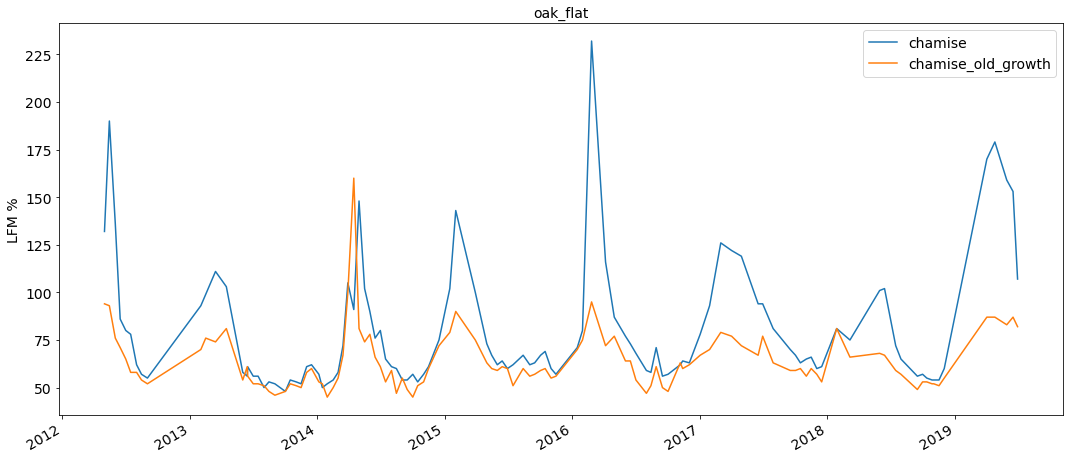

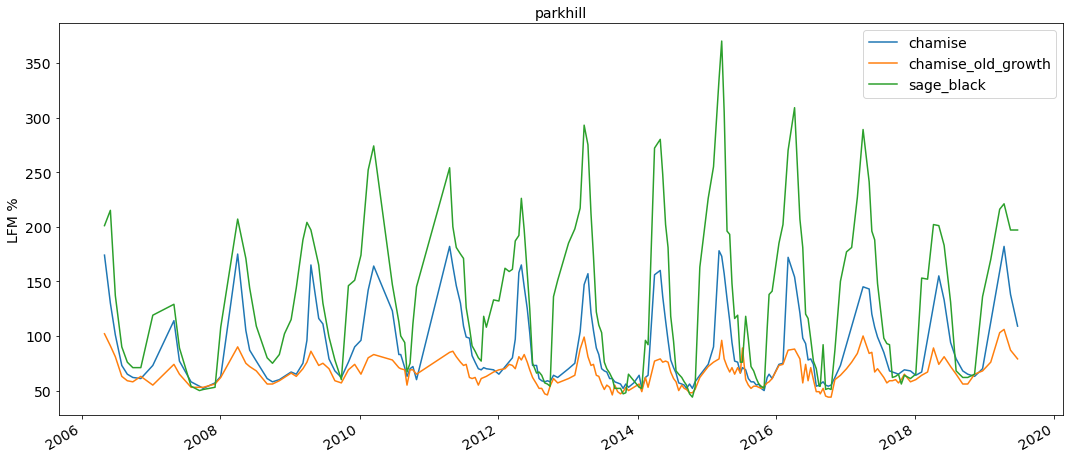

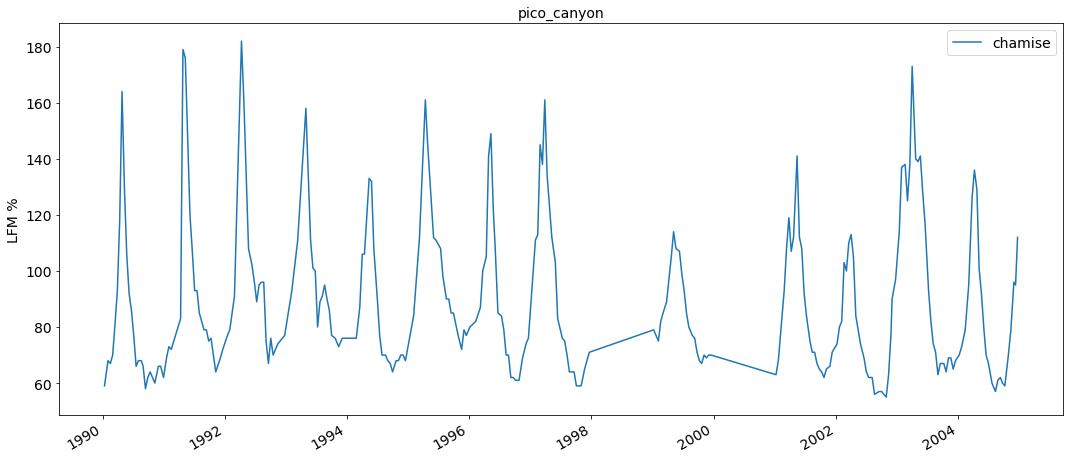

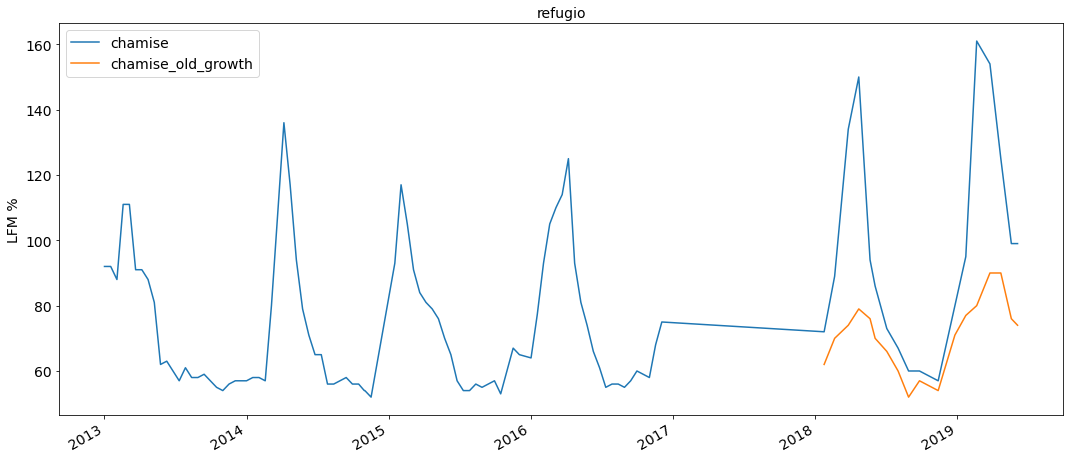

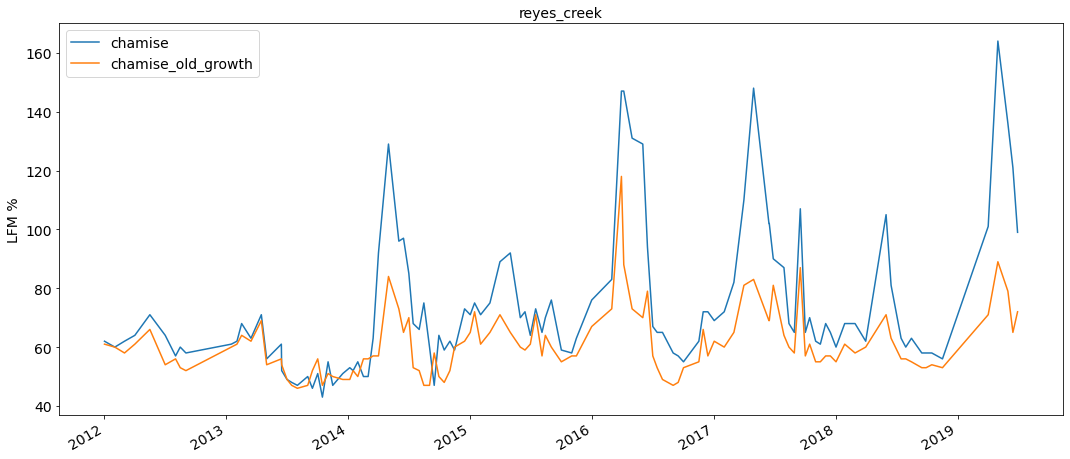

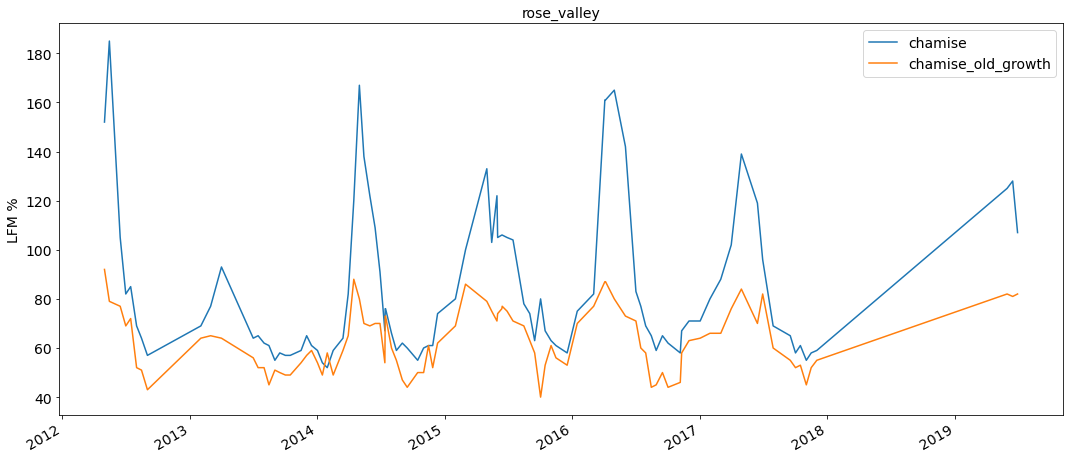

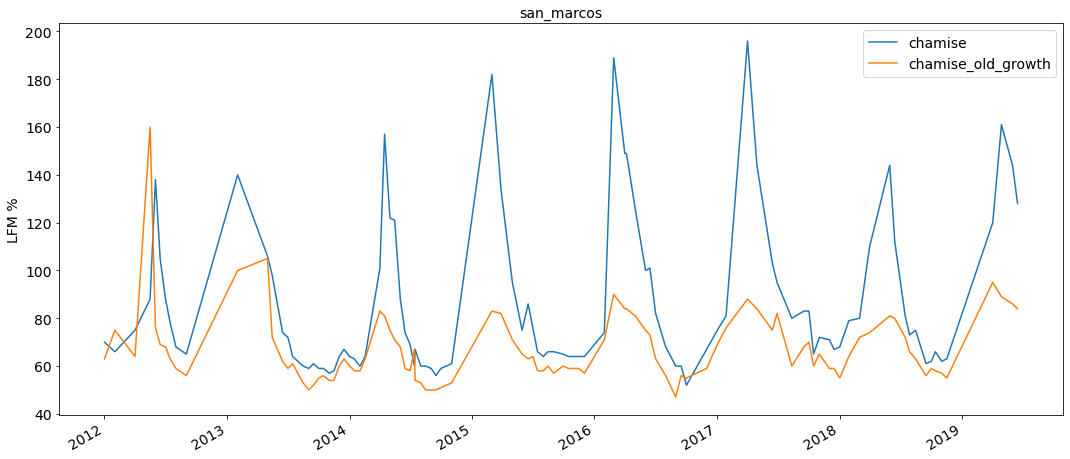

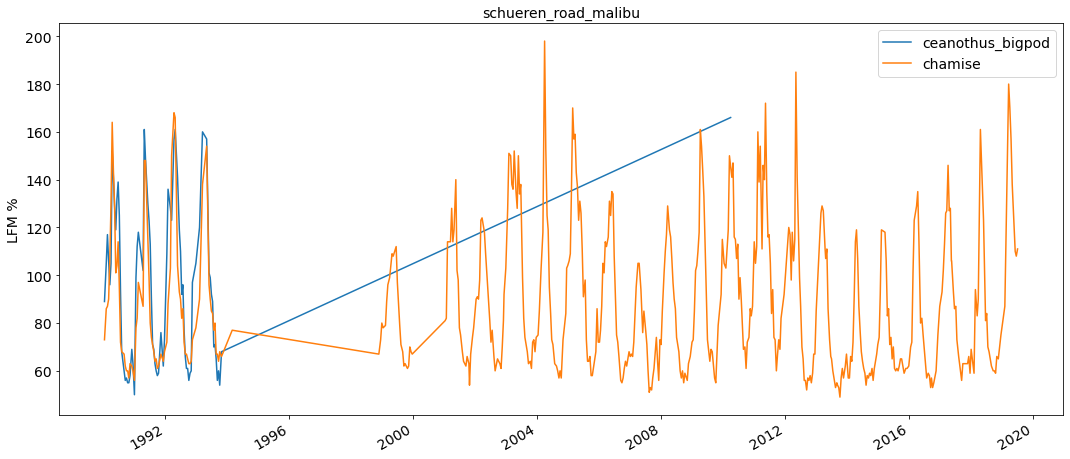

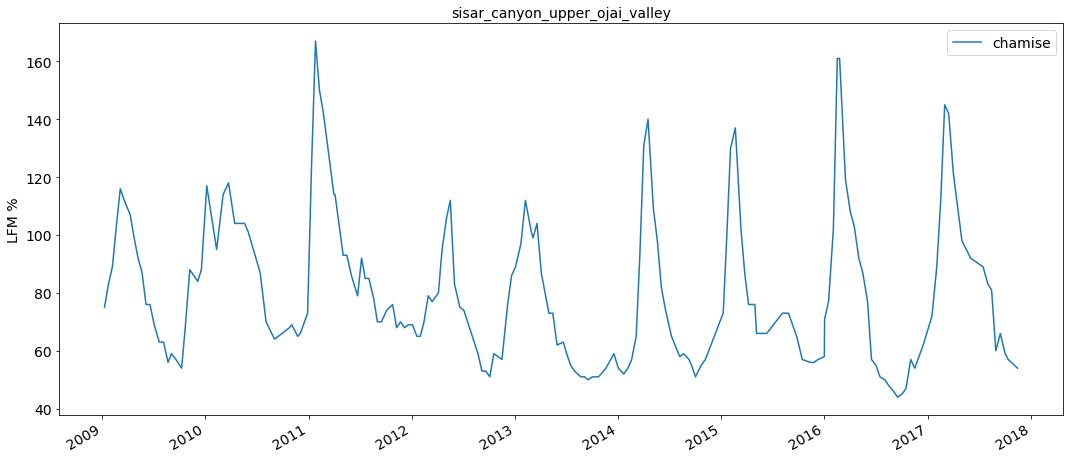

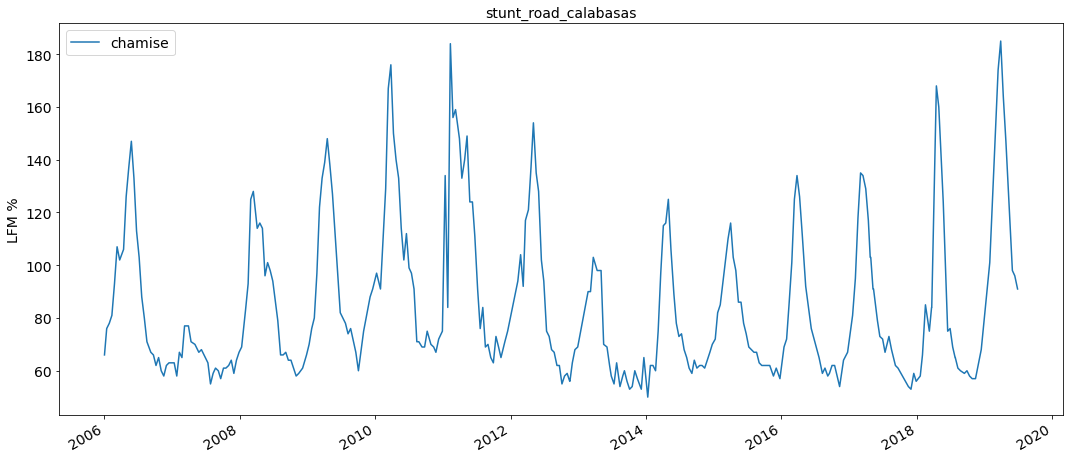

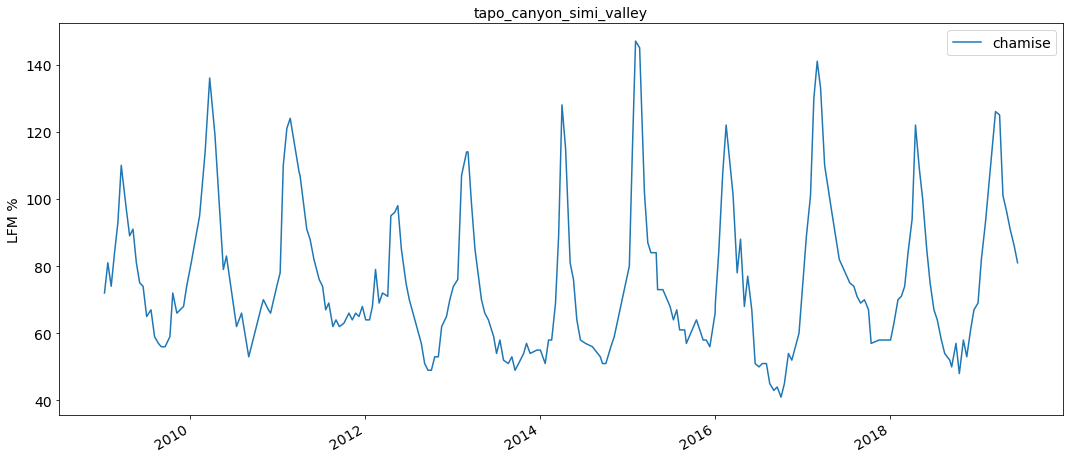

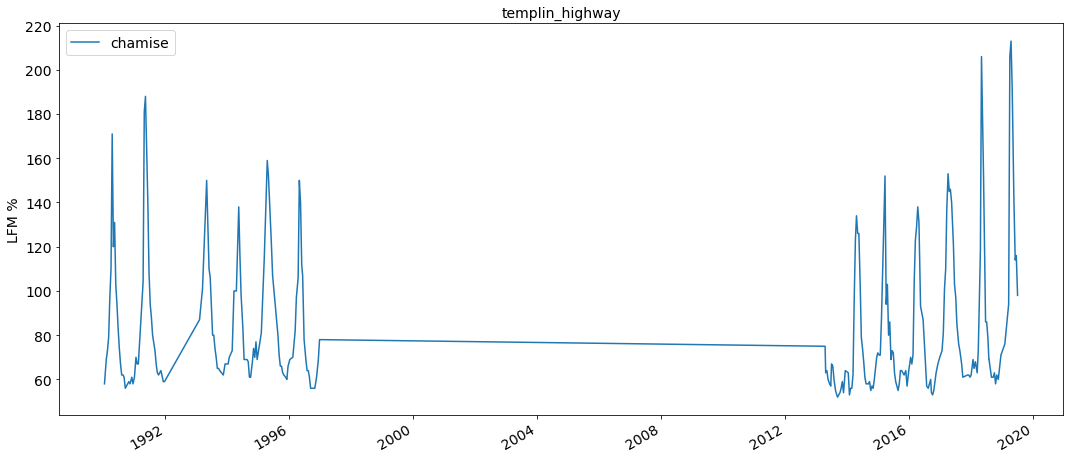

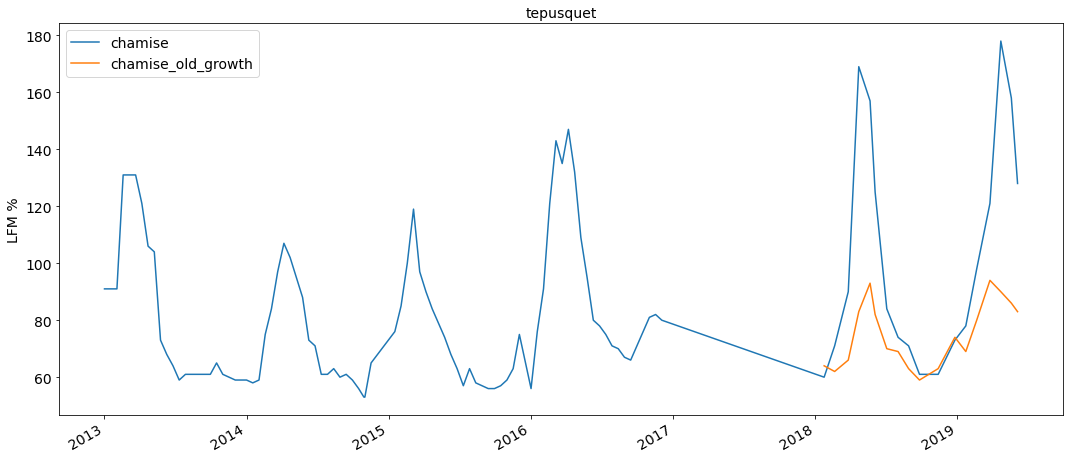

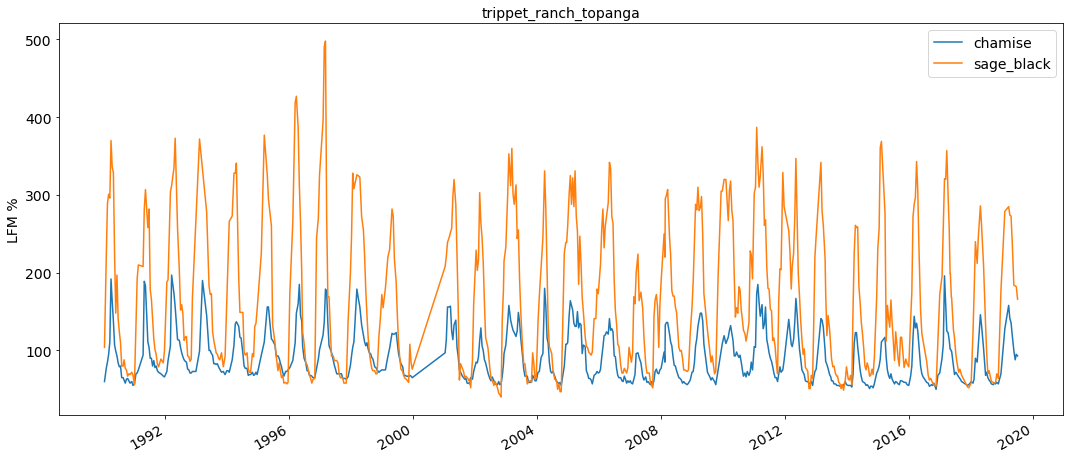

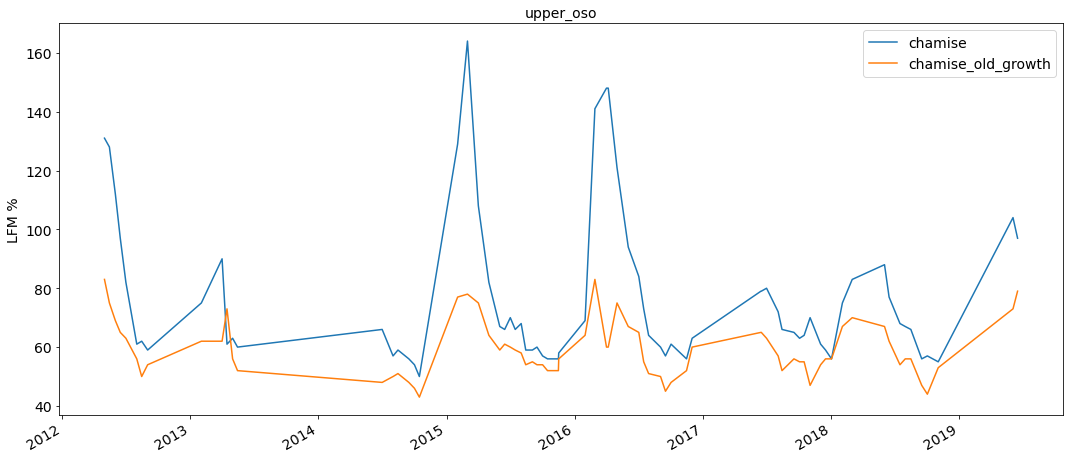

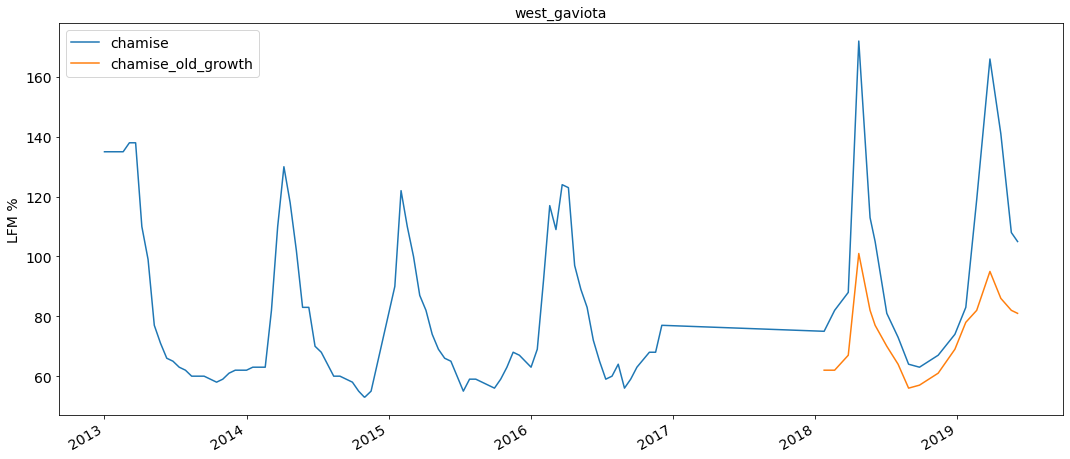

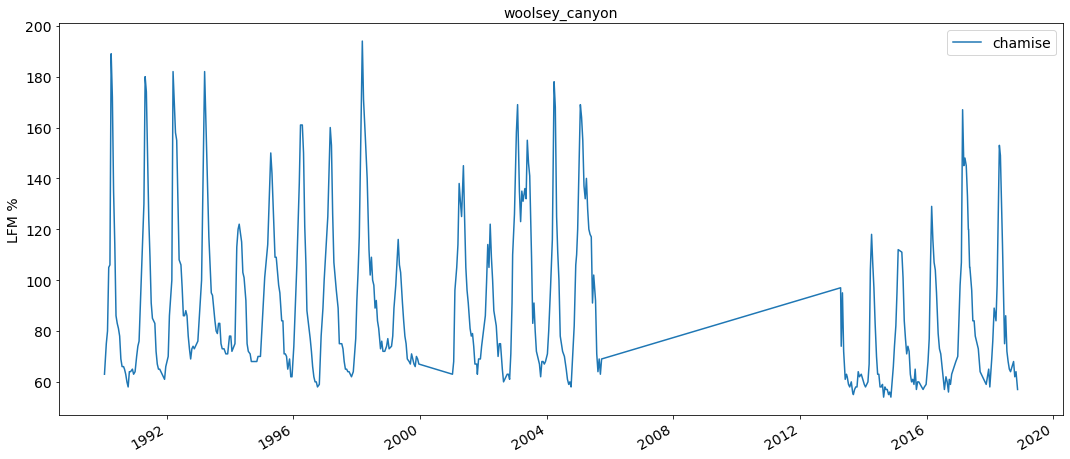

In [107]:
# Plot LFM time series at all locations with fuels grouped
for site_name in all_sites:
    site_df = lfm_clean.loc[lfm_clean['site'] == site_name]
    site_df = site_df.set_index("date")
    fig, axs = plt.subplots(figsize=(18, 8))
    site_df.groupby("fuel")["percent"].plot(fontsize=14, ax=axs)
    plt.ylabel("LFM %", fontsize=14);
    plt.xlabel("", fontsize=0);
    plt.legend(fontsize=14);
    plt.title(site_name, fontsize=14)
    plt.savefig('/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/sites/'+ site_name +'.png', bbox_inches='tight')

## Plot chamise, chamise new growth, and chamise old growth values
Need to do this before converting chamise_new_growth to chamise

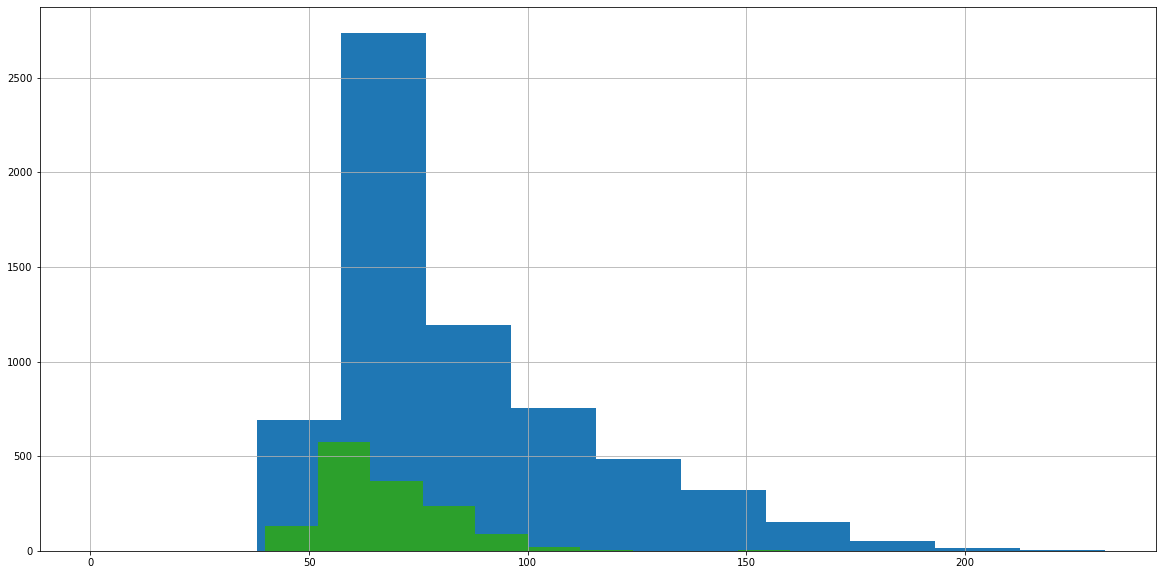

In [41]:
# Subset fuels
cham = lfm_clean.loc[lfm_clean['fuel'] == 'chamise']
cham_new = lfm_clean.loc[lfm_clean['fuel'] == 'chamise_new_growth']
cham_old = lfm_clean.loc[lfm_clean['fuel'] == 'chamise_old_growth']

# Plot histograms
cham['percent'].hist(figsize=[20,10], label='chamise');
cham_new['percent'].hist(label='chamise_new_growth');
cham_old['percent'].hist(label='chamise_old_growth');